In [1]:
import flor
df = flor.utils.latest(flor.dataframe("page_text"))
df

,document,document_value,page,page_value,projid,tstamp,filename,page_text
0,1,MBMF.pdf,1,0,document_parser,2025-08-31 11:11:09,doc_demux.py,M Y BONDAGE\nAND\nMY FREEDOM.\nHat I-gileasa S...
1,1,MBMF.pdf,2,1,document_parser,2025-08-31 11:11:09,doc_demux.py,"TO\nIONORABLE GIBBIT SHIT I ,\nAD A BLIOTT TON..."
2,1,MBMF.pdf,3,2,document_parser,2025-08-31 11:11:09,doc_demux.py,M\nY BONDAGE AND MY FREEDOM\nnarrate my person...
3,1,MBMF.pdf,4,3,document_parser,2025-08-31 11:11:09,doc_demux.py,G u a r a n t e e C a r d / 保 修 卡\nID No\n...
4,1,MBMF.pdf,5,4,document_parser,2025-08-31 11:11:09,doc_demux.py,MY BONDAGE AND MY FREEDOM\nnust prove himself ...
...,...,...,...,...,...,...,...,...
354,2,GutenbergMBMF.pdf,342,341,document_parser,2025-08-31 11:11:09,doc_demux.py,342\ndistribution of this or any Project Guten...
355,2,GutenbergMBMF.pdf,343,342,document_parser,2025-08-31 11:11:09,doc_demux.py,343\nto date contact information can be found ...
356,2,GutenbergMBMF.pdf,344,343,document_parser,2025-08-31 11:11:09,doc_demux.py,344\nSection 5. General Information About Proj...
357,2,GutenbergMBMF.pdf,345,344,document_parser,2025-08-31 11:11:09,doc_demux.py,345\nTable of Contents\nMY BONDAGE and MY FREE...


In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from user_defined_functions import get_headings, get_page_numbers

In [3]:
df["f_headings"] = df["page_text"].map(get_headings)
df

,document,document_value,page,page_value,projid,tstamp,filename,page_text,f_headings
0,1,MBMF.pdf,1,0,document_parser,2025-08-31 11:11:09,doc_demux.py,M Y BONDAGE\nAND\nMY FREEDOM.\nHat I-gileasa S...,"[M Y BONDAGE\nAND, WITH\nA]"
1,1,MBMF.pdf,2,1,document_parser,2025-08-31 11:11:09,doc_demux.py,"TO\nIONORABLE GIBBIT SHIT I ,\nAD A BLIOTT TON...","[TO, AD A BLIOTT TONIN OF, AND AS, A I D I T]"
2,1,MBMF.pdf,3,2,document_parser,2025-08-31 11:11:09,doc_demux.py,M\nY BONDAGE AND MY FREEDOM\nnarrate my person...,[M\nY BONDAGE AND MY FREEDOM]
3,1,MBMF.pdf,4,3,document_parser,2025-08-31 11:11:09,doc_demux.py,G u a r a n t e e C a r d / 保 修 卡\nID No\n...,[EC\nREP]
4,1,MBMF.pdf,5,4,document_parser,2025-08-31 11:11:09,doc_demux.py,MY BONDAGE AND MY FREEDOM\nnust prove himself ...,"[MY BONDAGE AND MY FREEDOM, I I]"
...,...,...,...,...,...,...,...,...,...
354,2,GutenbergMBMF.pdf,342,341,document_parser,2025-08-31 11:11:09,doc_demux.py,342\ndistribution of this or any Project Guten...,[]
355,2,GutenbergMBMF.pdf,343,342,document_parser,2025-08-31 11:11:09,doc_demux.py,343\nto date contact information can be found ...,[]
356,2,GutenbergMBMF.pdf,344,343,document_parser,2025-08-31 11:11:09,doc_demux.py,344\nSection 5. General Information About Proj...,[]
357,2,GutenbergMBMF.pdf,345,344,document_parser,2025-08-31 11:11:09,doc_demux.py,345\nTable of Contents\nMY BONDAGE and MY FREE...,"[CONTENTS, INTRODUCTION]"


In [4]:
df["f_page_nums"] = df["page_text"].map(get_page_numbers)
df

,document,document_value,page,page_value,projid,tstamp,filename,page_text,f_headings,f_page_nums
0,1,MBMF.pdf,1,0,document_parser,2025-08-31 11:11:09,doc_demux.py,M Y BONDAGE\nAND\nMY FREEDOM.\nHat I-gileasa S...,"[M Y BONDAGE\nAND, WITH\nA]","[85, 107, 1855]"
1,1,MBMF.pdf,2,1,document_parser,2025-08-31 11:11:09,doc_demux.py,"TO\nIONORABLE GIBBIT SHIT I ,\nAD A BLIOTT TON...","[TO, AD A BLIOTT TONIN OF, AND AS, A I D I T]","[07, 2, 1855, 1]"
2,1,MBMF.pdf,3,2,document_parser,2025-08-31 11:11:09,doc_demux.py,M\nY BONDAGE AND MY FREEDOM\nnarrate my person...,[M\nY BONDAGE AND MY FREEDOM],[]
3,1,MBMF.pdf,4,3,document_parser,2025-08-31 11:11:09,doc_demux.py,G u a r a n t e e C a r d / 保 修 卡\nID No\n...,[EC\nREP],"[1, 9144, 28046, 25, 18]"
4,1,MBMF.pdf,5,4,document_parser,2025-08-31 11:11:09,doc_demux.py,MY BONDAGE AND MY FREEDOM\nnust prove himself ...,"[MY BONDAGE AND MY FREEDOM, I I]",[]
...,...,...,...,...,...,...,...,...,...,...
354,2,GutenbergMBMF.pdf,342,341,document_parser,2025-08-31 11:11:09,doc_demux.py,342\ndistribution of this or any Project Guten...,[],"[342, 2, 2001, 3, 4, 3, 501, 3, 64, 6221541, 8..."
355,2,GutenbergMBMF.pdf,343,342,document_parser,2025-08-31 11:11:09,doc_demux.py,343\nto date contact information can be found ...,[],"[343, 4, 1, 5, 000, 50]"
356,2,GutenbergMBMF.pdf,344,343,document_parser,2025-08-31 11:11:09,doc_demux.py,344\nSection 5. General Information About Proj...,[],"[344, 5]"
357,2,GutenbergMBMF.pdf,345,344,document_parser,2025-08-31 11:11:09,doc_demux.py,345\nTable of Contents\nMY BONDAGE and MY FREE...,"[CONTENTS, INTRODUCTION]","[345, 5, 7, 9, 10, 13, 27, 34, 39, 46, 58, 65,..."


In [5]:
print(df.iloc[2]['page_text'])

M
Y BONDAGE AND MY FREEDOM
narrate my personal experience in public anti-slavery meetings,
and in sympathizing circles, when urged to do so by friends, with
whose views and wishes, ordinarily, it were a pleasure to comply.
In my letters and speeches, I have generaly aimed to discuss the
question of Slavery in the light of fundamental principles, and
upon facts, notorious and open to all ; making, I trust, no more
of the fact of my own former enslavement, than circumstances
seemed absolutely to require. I have never placed my opposition
to slavery on a basis so narrow as my own enslavement, but
rather upon the indestructible and unchangeable laws of human
nature, every one of which is perpetually and ﬂagrantly violated
by the slave system. I have also felt that it was best for those hav-
ing histories worth the writing-or supposed to be so-to com-
mit such work to hands other than their own. To write of one's
self, in such a manner as not to incur the imputation of weak.
ness, vanity, a

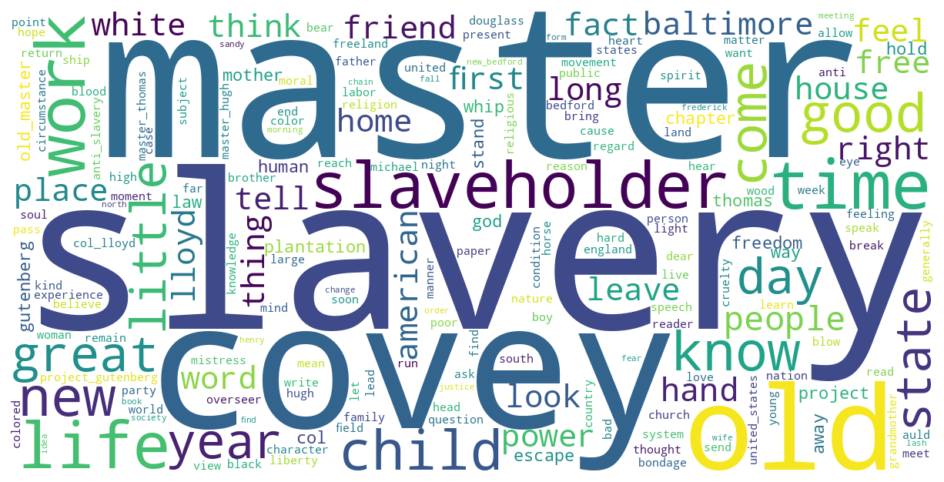

In [8]:
import spacy
from wordcloud import STOPWORDS

# 1) Documents: use each page as a separate document so min_df / max_df make sense
docs = df.page_text.tolist()

# 2) Setup spaCy and stopwords
nlp = spacy.load("en_core_web_sm", disable=["ner","parser","textcat"])
extra_stops = set(STOPWORDS) | {"figure", "like", "use", "etc"}
spacy_stops = {w.lower() for w in nlp.Defaults.stop_words}
stops = extra_stops | spacy_stops

# 3) Lemma-based analyzer that now also yields bigrams
def lemma_analyzer(doc):
    tokens = []
    for t in nlp(doc):
        if not t.is_alpha:
            continue
        lemma = t.lemma_.lower()
        if lemma in stops:
            continue
        tokens.append(lemma)
    # unigrams
    for tok in tokens:
        yield tok
    # bigrams
    for w1, w2 in zip(tokens, tokens[1:]):
        yield f"{w1} {w2}"

# 4) TF–IDF over lemmas + bigrams (ngram_range removed because analyzer emits both)
from sklearn.feature_extraction.text import TfidfVectorizer
min_df_val = 2 if len(docs) >= 2 else 1
vec = TfidfVectorizer(
    analyzer=lemma_analyzer,
    max_features=5500,
    min_df=min_df_val,
    max_df=0.6 if len(docs) > 3 else 1.0
)
X = vec.fit_transform(docs)

# Aggregate TF-IDF scores across all documents (sum) for word cloud weights
weights_arr = X.sum(axis=0).A1
weights = dict(zip(vec.get_feature_names_out(), weights_arr))

# 5) Make bigrams render as single tokens in the cloud
weights_wc = {k.replace(" ", "_"): v for k, v in weights.items()}

# 6) Word cloud
from wordcloud import WordCloud  # already imported earlier, safe if not re-run
import matplotlib.pyplot as plt   # already imported earlier
wc = WordCloud(
    width=1200, height=600,
    background_color="white",
    collocations=False,
    stopwords=extra_stops,
    random_state=50
).generate_from_frequencies(weights_wc)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()